# LightGCN

#### Approach:
- In this notebook we implement an adapted version of the LightGCN model for collaborative filtering from the [LightGCN paper](https://arxiv.org/pdf/2002.02126.pdf).
- The adaptation is necessary, since the original model is meant for recommendation (ranking), and not matrix completion.
- From the LightGCN paper we implement the multi-layer, symmetrically normalized, message passing mechanism.
- The adaptation comes from the [GCMC paper](https://www.kdd.org/kdd2018/files/deep-learning-day/DLDay18_paper_32.pdf), where they propose stacking the layer embeddings as way to aggregate information from the message passing (for each user and for each item separately). The LightGCN paper used a simple averaging of the layer embeddings.
- To make the final predictions, we use an MLP, which is trained to predict the ratings, which comes from the [neural collaborative filtering paper](https://arxiv.org/pdf/1708.05031.pdf).

#### Choices
- No mini-batching of training data, doesn't improve performance (according to paper), slows convergence down. 
- Regularization through dropout (from the GCMC paper), and L2 regularization (weight decay in the Adam optimizer).

#### Resources:
- [LightGCN implementation](https://www.youtube.com/watch?v=LPfCmwEOsds)
- [Explanation of message passing and normalization](https://www.youtube.com/watch?v=CwHNUX2GWvE&t=3s)
- [Graph Attention Networks implementation](https://www.youtube.com/watch?v=CwsPoa7z2c8&list=PLgWXxgQ6T1Ou8_52nIZRMhrn1qFT73b-d&index=3)

## 1. Setup
- import libraries, functions and raw data
- define constants (n_users, n_items)
- inspect raw data
- train-val split
- create coo lists
- create full bipartite graph matrix
- compute message-passing-matrices

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# set device for computations
if torch.device("mps"):
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Device:", device)

# number of users and items
N_u, N_v = (10000, 1000)
print("Full matrix entries: 10 MIO")

train_df = pd.read_csv('raw_data/data_train.csv')
train_ids = train_df.Id 
submission_df = pd.read_csv('raw_data/sampleSubmission.csv')
submission_ids = submission_df.Id
print("Observed entries (train + val):", train_df.shape[0])
print("Density:", train_df.shape[0] / (N_u * N_v))
train_df.head()

Device: mps
Full matrix entries: 10 MIO
Observed entries (train + val): 1176952
Density: 0.1176952


,Id,Prediction
0,r44_c1,4
1,r61_c1,3
2,r67_c1,4
3,r72_c1,3
4,r86_c1,5


Index(['Id', 'Prediction'], dtype='object')
[RangeIndex(start=0, stop=1176952, step=1), Index(['Id', 'Prediction'], dtype='object')]
(1176952, 2)
min 1
max 5
mean 3.8572805008190647
       Id  Prediction
0  r44_c1           4
1  r61_c1           3
2  r67_c1           4


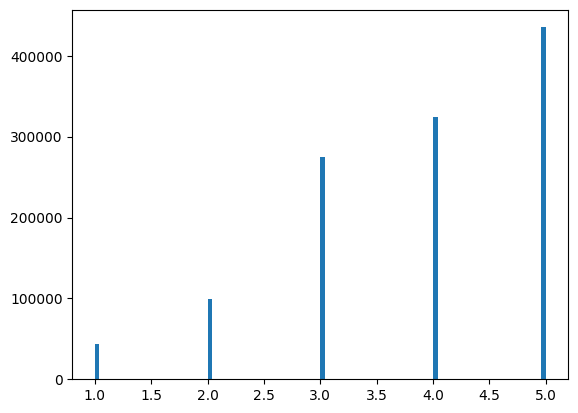

In [3]:
# inspect data

# data format
print(train_df.columns)
print(train_df.axes)
print(train_df.shape)
print("min", train_df['Prediction'].min())
print("max", train_df['Prediction'].max())
print("mean", train_df['Prediction'].mean())
print(train_df[0:3])

# data distribution
plt.hist(train_df['Prediction'], bins=100)
plt.show()

In [4]:
# Extract triplets (user, item, prediction)
def extract_users_items_predictions(data):
    users, movies = \
        [np.squeeze(arr) for arr in np.split(data.Id.str.extract('r(\d+)_c(\d+)').values.astype(int) - 1, 2, axis=-1)]
    predictions = data.Prediction.values
    return users, movies, predictions

# Adjacency lists: observed values edge index (src, tgt) and ratings (values)
submission_users, submission_movies, _ = extract_users_items_predictions(submission_df)
orig_users, orig_items, orig_ratings = extract_users_items_predictions(train_df)

In [5]:
# Create a ratings matrix from the triplets
original_ratings_matrix = np.zeros((N_u, N_v))
original_ratings_matrix[orig_users, orig_items] = orig_ratings

# Define mask for later use
mask = original_ratings_matrix != 0

In [6]:
# standardize ratings of original matrix

def standardize_excluding_zeros(ratings, mask):
    # Compute means and stds of non-zero elements
    sums = np.sum(ratings * mask, axis=0, keepdims=True)
    counts = np.sum(mask, axis=0, keepdims=True)
    means = sums / counts
    variances = np.sum(((ratings - means) * mask) ** 2, axis=0, keepdims=True) / counts
    stds = np.sqrt(variances)
    standardized_ratings = (ratings - means) / stds

    # Preserve original zeros
    standardized_ratings[~mask] = 0  

    # For simplicity make matrix of means and stds with same shape as ratings
    means = np.repeat(means, ratings.shape[0], axis=0)
    stds = np.repeat(stds, ratings.shape[0], axis=0)

    return standardized_ratings, means, stds

# Standardize the ratings matrix across columns (items) and extract ratings list for observed values
standardized_ratings_matrix, means, stds = standardize_excluding_zeros(original_ratings_matrix, mask)
standardized_ratings = standardized_ratings_matrix[orig_users, orig_items]

In [7]:
# test reverse standardization

# !!! Only used for testing
def reverse_standardize(standardized_ratings, mask, means, stds):
    # shape of all inputs: (n_users, n_items)
    reversed_ratings = standardized_ratings * stds + means
    reversed_ratings[~mask] = 0  # Preserve original zeros
    return reversed_ratings

recovered_ratings_matrix = reverse_standardize(standardized_ratings_matrix, mask, means, stds)
assert np.allclose(recovered_ratings_matrix, original_ratings_matrix, equal_nan=True)

In [8]:
# split into training and validation set

train_users, val_users, train_items, val_items, standardized_train_ratings, standardized_val_ratings = \
    train_test_split(orig_users, orig_items, standardized_ratings, test_size=0.005, random_state=42)

print("Train set size:", len(train_users))
print("Val set size:", len(val_users))

Train set size: 1171067
Val set size: 5885


In [9]:
# convert to torch tensors and move to device
standardized_train_ratings = torch.tensor(standardized_train_ratings, dtype=torch.float).to(device)
train_users = torch.tensor(train_users, dtype=torch.long).to(device)
train_items = torch.tensor(train_items, dtype=torch.long).to(device)

standardized_val_ratings = torch.tensor(standardized_val_ratings, dtype=torch.float).to(device)
val_users = torch.tensor(val_users, dtype=torch.long).to(device)
val_items = torch.tensor(val_items, dtype=torch.long).to(device)

In [10]:
def create_bipartite_graph(users, items, preds):
    """
    Create a bipartite graph from the users, items and predictions.
        graph: [[0, R], [R^T, 0]] 
        shape: [ [N_u x N_u], [N_u x N_v], 
                 [N_v x N_u], [N_v x N_v] ]
    """
    # Create the upper left block (N_u x N_u) with zeros
    upper_left = torch.zeros((N_u, N_u), device=device)
    
    # Create the upper right block (N_u x N_v) and fill with preds
    upper_right = torch.zeros((N_u, N_v), device=device)
    upper_right[users, items] = preds

    # Create the lower left block (N_v x N_u) and fill with preds (transposed)
    lower_left = torch.zeros((N_v, N_u), device=device)
    lower_left[items, users] = preds

    # Create the lower right block (N_v x N_v) with zeros
    lower_right = torch.zeros((N_v, N_v), device=device)

    # Concatenate the blocks to form the bipartite adjacency matrix
    upper_block = torch.cat([upper_left, upper_right], dim=1)
    lower_block = torch.cat([lower_left, lower_right], dim=1)
    A = torch.cat([upper_block, lower_block], dim=0)

    return A

def create_degree_matrix(weighted_adjacency_matrix):
    # Binarize the weighted adjacency matrix: where not 0 put 1
    binarized_adjacency_matrix = (weighted_adjacency_matrix != 0).int()
    # Sum the binarized adjacency matrix along axis 1 to get the degree of each node
    degrees = torch.sum(binarized_adjacency_matrix, dim=1)
    # Create a diagonal matrix with the degrees
    degree_matrix = torch.diag(degrees)
    return degree_matrix

def create_inverse_sqrt_degree_matrix(degree_matrix):
    # Get the degrees from the diagonal of the degree matrix
    degrees = degree_matrix.diag()
    # Compute the inverse square root of the degrees
    inverse_sqrt_degrees = 1.0 / torch.sqrt(degrees)
    # Create a diagonal matrix with the inverse square root degrees
    inverse_sqrt_degree_matrix = torch.diag(inverse_sqrt_degrees)
    return inverse_sqrt_degree_matrix

In [11]:
# TRAIN (train): Create matrices for message passing

# Create the bipartite graph adjacency matrix
A_train = create_bipartite_graph(train_users, train_items, standardized_train_ratings)
D_train = create_degree_matrix(A_train)
D_norm_train = create_inverse_sqrt_degree_matrix(D_train)

# Compute the normalized adjacency matrix
A_tilde_train = D_norm_train @ A_train @ D_norm_train
A_tilde_train = A_tilde_train.to(device)

## 2. Modeling

Once we have the edge indexes and the bipartite graphs, we can start we have everything for the model and the training.

The models:
- avg: averages the embeddings over the layers
- concat linear: concatenates the embeddings over the layers and projects them to the output space
- concat nonlinear: concatenates the embeddings over the layers, and projects to the output space with a 2-layer MLP

In [12]:
# implementation with mat mul instead of sparse message passing

class LightGCN(nn.Module):
    def __init__(self, A_tilde, embedding_dim, n_users, n_items, n_layers, init_emb_std=0.1, model_name='concat_linear'):
        super(LightGCN, self).__init__()
        self.A_tilde = A_tilde  # A_tilde: normalized adjacency matrix
        self.K = embedding_dim
        self.N_u = n_users
        self.N_v = n_items
        self.L = n_layers
        self.model_name = model_name    

        # initialize embeddings
        self.E_u = nn.Embedding(num_embeddings=self.N_u, embedding_dim=self.K)
        self.E_v = nn.Embedding(num_embeddings=self.N_v, embedding_dim=self.K)
        nn.init.normal_(self.E_u.weight, std=init_emb_std)
        nn.init.normal_(self.E_v.weight, std=init_emb_std)

        if model_name == 'avg':
            self.transform = nn.Linear(self.K * 2, 1)
        elif model_name == 'concat_linear':
            self.transform = nn.Linear(self.K * 2 * (self.L + 1), 1)
        elif model_name == 'concat_nonlinear':
            self.transform = nn.Sequential(
                nn.Linear(self.K * 2 * (self.L + 1), self.K),  # if L=1, the linear projects from 4K to 2K
                nn.GELU(),          # try 4K->K->1, 4K->2K->1, 4K->2K->K->1
                nn.Linear(self.K, 1)  #,                
                # nn.GELU(),
                # nn.Linear(self.K, 1)
            )
        elif model_name == 'attention':
            self.W = nn.Parameter(torch.Tensor(self.K, self.K))
            self.a = nn.Parameter(torch.Tensor(2 * self.K, 1))
            nn.init.xavier_uniform_(self.W)
            nn.init.xavier_uniform_(self.a)
        elif model_name == 'mh_attention':
            pass
        else:
            raise ValueError(f"Unknown model_name: {model_name}")

    def forward(self, users, items):
        E_0 = torch.cat([self.E_u.weight, self.E_v.weight], dim=0)  # size (N_u + N_v) x K
        assert E_0.shape == (self.N_u + self.N_v, self.K) 

        embs = [E_0]
        E_l = E_0

        # TODO: check that this is the same as message passing
        # propagate provided by MessagePassing 
        for l in range(self.L):
            E_l = torch.mm(self.A_tilde, E_l)  # shape (N_u + N_v) x K
            embs.append(E_l) 

        # combine embeddings
        if self.model_name == 'avg':
            print(embs[0].shape)
            embs = torch.stack(embs, dim=1)  # shape: (L+1) x (N_u + N_v) * K -stack-> (N_u + N_v) x (L+1) * K
            print(embs.shape)
            E_final = torch.mean(embs, dim=1)  # shape (N_u + N_v) x K
            print(E_final.shape)
            E_u_final, E_v_final = torch.split(E_final, [self.N_u, self.N_v], dim=0)
            # select embeddings for users and items (aligned)
            E_u_final = E_u_final[users]
            E_v_final = E_v_final[items]  # shape (N_train, K)
            out = self.transform(torch.cat([E_u_final, E_v_final], dim=1)).squeeze()  # shape: (N_train, 1) -squeeze-> (N_train,)

        elif self.model_name == 'concat_linear' or self.model_name == 'concat_nonlinear':
            E_final = torch.cat(embs, dim=1)  # shape (N_u + N_v) x (K * (L + 1))
            E_u_final, E_v_final = torch.split(E_final, [self.N_u, self.N_v], dim=0)
            # select embeddings for users and items (aligned)
            E_u_final = E_u_final[users]
            E_v_final = E_v_final[items]  # shape (N_train, K * (L + 1))

            # projection to output space
            out = self.transform(torch.cat([E_u_final, E_v_final], dim=1)).squeeze()  

        elif self.model_name == 'attention':
            # we pick the average embeddings for users and items from the LightGCN approach for the encoder
            # for the decoder we use attention mechanism 
            # e_ij = LeakyReLU( a^T [(W * E_u_i) concat (W * E_v_j)] ), where a is a learnable vector in R^2K and W is a learnable matrix in R^{K x K}
            # alpha_ij = softmax(e_ij) = exp(e_ij) / sum_{k=1}^{N(i)} exp(e_ik)
            # h_i = LeakyReLU( sum_{j=1}^{N(i)} alpha_ij * E_v_j )
            # use MLP to predict the rating
            

            pass

        elif self.model_name == 'mh_attention':
            pass
        return out 
    
    def get_ratings(self, users, items):
        return self.forward(users, items)

## 3. Training

### Optimal conditions to retrain on full dataset:
- training is stable: the loss decreases monotonically
- validation loss follows the training loss closely
- on different initializations the model converges to the same loss with the same amount of epochs

### Comments on the results:
- i guess now that I standardize the embeddings, the learning rate should be lower 
- it seems initialization of embeddings is important try 0.075 and other values
- also the learning rate plays a big role
- the epochs should be placed around 800 to not overfit
- concat non-linear seems to be best on training, not sure if it is overfitting

### TODO:
- write new hyperparam tuning loop:
    - try with and without standardization
    - try dropout
    - use cross validation to tune hyperparams
    - build tuning pipelines for different models
    - create multiple instances of same model, sometimes it converges to different local minima (in the case of my current best it happens 1/5 that it goes in 300 epochs to 0.95, than goes up dramatically again, but then comes down again)
- build different classes for different models
- implement KL-divergence in loss function to approximate the original distribution of rankings
- implement different models:
    - implement model with separate rakings message passing
    - implement attention model
    - try an ensamble of models

### Done:
- try Z-score normalization
- separate training and val data
- save model every epoch if loss improved from last best
- save init embeddings to reuse them later or for other models

In [79]:
# Set up training loop

# Model and optimizer hyperparameters
L=1
K=30
MODEL_NAME="concat_nonlinear"
INIT_EMBS_STD=0.1
LR=0.08
WEIGHT_DECAY=1e-04

# Train loop hyperparameters
EPOCHS=500
STOP_THRESHOLD=1e-06

model = LightGCN(A_tilde_train, K, N_u, N_v, L, model_name=MODEL_NAME).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.MSELoss()

# Remove models from previous runs
if os.path.exists("best_val_model.pth"):
    os.remove("best_val_model.pth")

In [80]:
# Train loop variables (when experimenting manually, we might resume training by re-running the training loop cell)
train_rmse = []
val_rmse = []
best_val_loss = np.inf 

In [81]:
# Train loop
for epoch in range(EPOCHS):
    model.train()
    
    optimizer.zero_grad()
    pred_train_ratings = model.forward(train_users, train_items)
    J = loss_fn(pred_train_ratings, standardized_train_ratings)
    J.backward()
    optimizer.step()

    train_rmse.append(J.item())

    # validation
    with torch.no_grad():
        model.eval()
        val_pred_ratings = model.forward(val_users, val_items)
        standardized_val_loss = loss_fn(val_pred_ratings, standardized_val_ratings)

        # save model if best validation loss
        if standardized_val_loss < best_val_loss and standardized_val_loss < 0.94:
            best_val_loss = standardized_val_loss
            torch.save(model.state_dict(), "best_val_model.pth")

        val_rmse.append(standardized_val_loss.item())

    # report results
    print(f"Epoch {epoch + 1}, Train Loss: {round(train_rmse[-1], 5)}, Standardized Val Loss: {round(standardized_val_loss.item(), 5)}")

    # early stopping: loss decreased and diff below threshold
    if epoch > 0 \
            and train_rmse[-2] - train_rmse[-1] > 0 \
            and abs(train_rmse[-2] - train_rmse[-1]) < STOP_THRESHOLD:
        break   

Epoch 1, Train Loss: 1.01691, Standardized Val Loss: 1.01917
Epoch 2, Train Loss: 1.02096, Standardized Val Loss: 1.01864
Epoch 3, Train Loss: 1.00981, Standardized Val Loss: 1.01006
Epoch 4, Train Loss: 1.01167, Standardized Val Loss: 0.97622
Epoch 5, Train Loss: 0.96581, Standardized Val Loss: 0.97198
Epoch 6, Train Loss: 0.9543, Standardized Val Loss: 0.95518
Epoch 7, Train Loss: 0.93771, Standardized Val Loss: 0.95713
Epoch 8, Train Loss: 0.94394, Standardized Val Loss: 0.94985
Epoch 9, Train Loss: 0.93629, Standardized Val Loss: 0.96158
Epoch 10, Train Loss: 0.94401, Standardized Val Loss: 0.95379
Epoch 11, Train Loss: 0.93332, Standardized Val Loss: 0.95976
Epoch 12, Train Loss: 0.93871, Standardized Val Loss: 0.94938
Epoch 13, Train Loss: 0.92877, Standardized Val Loss: 0.95802
Epoch 14, Train Loss: 0.93786, Standardized Val Loss: 0.94809
Epoch 15, Train Loss: 0.93164, Standardized Val Loss: 0.95123
Epoch 16, Train Loss: 0.93114, Standardized Val Loss: 0.95546
Epoch 17, Train Lo

KeyboardInterrupt: 

Min training loss: 0.8496273159980774
Min validation loss: 0.9180091023445129
Min validation loss at epoch: 303


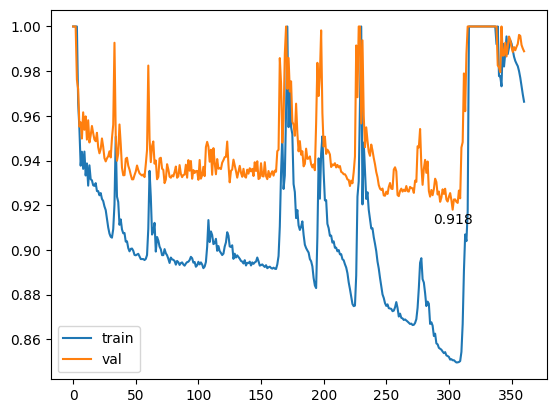

In [100]:
# Training stats
print("Min training loss:", min(train_rmse))
print("Min validation loss:", min(val_rmse))
print("Min validation loss at epoch:", val_rmse.index(min(val_rmse)))

# Replace values above 10 with 10 in the rmse lists
train_rmse_plot = [min(1, x) for x in train_rmse]
val_rmse = [min(1, x) for x in val_rmse]

# Plot train and val rmse
plt.plot(train_rmse_plot, label='train')
plt.plot(val_rmse, label='val')
# annotate min val loss
plt.annotate(round(min(val_rmse), 4), (val_rmse.index(min(val_rmse)), min(val_rmse)), textcoords="offset points", xytext=(0,-10), ha='center')


plt.legend()
plt.show()

## 4. Post-processing

In [83]:
# Read model that achieved best validation loss
model.eval()
model.load_state_dict(torch.load("best_val_model.pth"))

# Get predictions for submission
final_ratings = model.get_ratings(submission_users, submission_movies).cpu().detach().numpy()

In [84]:
# test loss on validation set
with torch.no_grad():
    model.eval()
    val_pred_ratings = model.forward(val_users, val_items)
    standardized_val_loss = loss_fn(val_pred_ratings, standardized_val_ratings)
    print("Standardized loss on validation set:", standardized_val_loss.item())

Standardized loss on validation set: 0.9180091023445129


min: -3.250269
max: 1.7973965
mean: -0.012958117


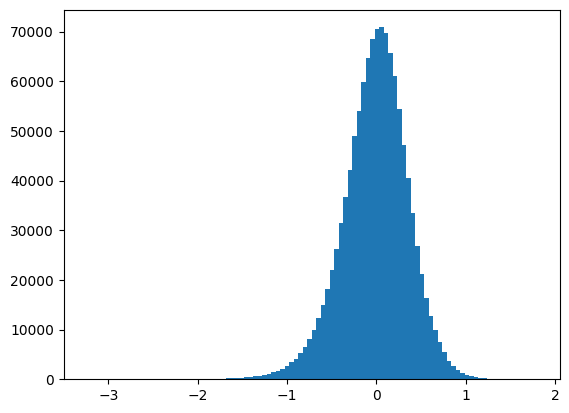

In [85]:
# Check min and max of final_ratings
print("min:", final_ratings.min())
print("max:", final_ratings.max())
print("mean:", final_ratings.mean())

# Check distribution of final_ratings
plt.hist(final_ratings.flatten(), bins=100)
plt.show()

In [86]:
# Reverse standardization

# Fill matrix with predictions
final_ratings_matrix = np.zeros((N_u, N_v))
final_ratings_matrix[submission_users, submission_movies] = final_ratings

# Reverse standardization (no mask needed)
def reverse_standardization(submission_matrix, means, stds):
    # shape of all inputs: (n_users, n_items)
    reversed_ratings = submission_matrix * stds + means
    return reversed_ratings

final_ratings_matrix = reverse_standardization(final_ratings_matrix, means, stds)

# extract numpy array from ratings matrix
final_ratings = final_ratings_matrix[submission_users, submission_movies]
final_ratings = torch.tensor(final_ratings, dtype=torch.float).to(device)

In [87]:
# Clip at 1 and 5

# check min and max of final_ratings_rounded
print("min:", final_ratings.min().item())
print("max:", final_ratings.max().item())
print("mean:", final_ratings.mean().item())

# Count the number of values under 1 and over 5
count_under_1 = (final_ratings < 1).sum().item()
count_over_5 = (final_ratings > 5).sum().item()
print("count_over_5:", count_over_5)
print("count_under_1:", count_under_1)

# Clip the values to be within the range [1, 5]
final_ratings = final_ratings.clamp(1, 5).cpu().detach().numpy()

min: -0.3623500466346741
max: 6.046236991882324
mean: 3.8440005779266357
count_over_5: 12206
count_under_1: 115


min: 1.0
max: 5.0
mean: 3.8427276611328125


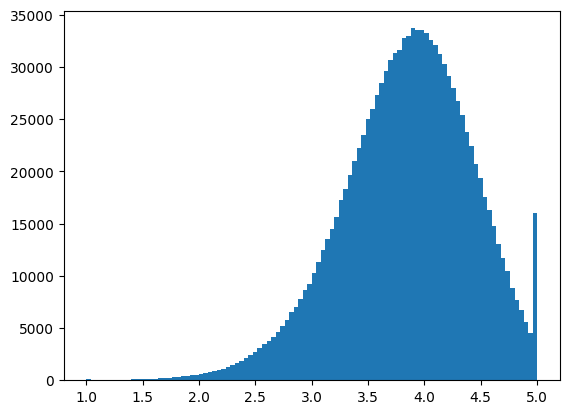

In [88]:
# check min and max of final_ratings
print("min:", final_ratings.min().item())
print("max:", final_ratings.max().item())
print("mean:", final_ratings.mean().item())

# check distribution of final_ratings
plt.hist(final_ratings.flatten(), bins=100)
plt.show()

# 5. Submission

In [89]:
# save submission

def to_submission_format(users, movies, predictions):
    return pd.DataFrame(data={'Id': ['r{}_c{}'.format(user + 1, movie + 1) for user, movie in zip(users, movies)],
                              'Prediction': predictions})

submission = to_submission_format(submission_users, submission_movies, final_ratings)

submission.to_csv('submission.csv', index=False)

# 6. Save model

We save the model that achieved best performance on Kaggle, just in case.

In [90]:
# Flag for saving
KAGGLE_BEST = False

# Save model
if KAGGLE_BEST:
    torch.save(model, f'kaggle_model.pth')